In [2]:
### GOAL: Repeat horseshoe experiment with Concrete RVs

# Numerical analysis
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.nn import sigmoid

# Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set pseudo random number key
prng_key = random.PRNGKey(2)

In [3]:
# MODEL CONSTANTS
n_realizations = 2
N = 100 # number of observations
D = 200 
pstar = 20 # number of non-zero predictors
sigma = 1 # noise parameter

# MCMC PARAMETERS
num_warmup = 500
num_samples = 1000
num_chains = 1

# TESTING
prob = pstar / D
alphas = jnp.zeros(D)
alphas += (prob) / (1-prob)
A_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lams = [2, 1, 1/2, 1/10, 1/100]

<h1> Generating Data </h1>

$$\begin{align*} 
y_i &\sim \sum_{j=1}^D \beta_jx_j + \epsilon_i \\
\epsilon_i &\sim N(0, \sigma^2), \;\; i = 1, ..., N
\end{align*}$$
Similarly to Piironen's toy example, We generate $100$ data realizations. Our true parameter vector $\beta^*$ has length $D=400$ and $p^*=20$ non-zero entries with some value $A \in$ $\{1, 2, ..., 10\}$. The total number of observations per realization is $n=400$.

In [4]:
def generate_data(A, sigma):
  """
  Generate synthetic data for a linear regression model with noise.

  Parameters:
    A: float
       The magnitude of true non-zero signals
    sigma: float
       Standard deviation of the noise
  Returns:
    X: ndarray
      array of shape (N,D) where N is the number of observatins and D is the number of features
    y: ndarray
      array of shape (N,) containing the target values
  """
  X = np.random.normal(size=(N, D)) # NxD
  beta_star = np.zeros([D]) # Initialise
  beta_star[:pstar] += A   # Add signal
  y = jnp.dot(X, beta_star) # Y = X * beta
  y += np.random.normal(0, sigma, size=N)  # Add noise to Y
  return X, y

<h2> Defining the Model </h2>

$$\begin{align*} 
y_i &\sim \sum_{j=1}^D \beta_jX_j + \epsilon_i \\
\beta_j &= \gamma_jA\\
\gamma_j &= \sigma \left(\frac{L_j + \log\alpha_j}{\lambda}\right) \text{  for   } j = 1, ..., D \\
L_j &= \log (U_j) - \log (1-U_j)\\
U_j &\sim \text{Uniform}(0, 1)
\end{align*}$$




Note that in order for the model to work correctly, $\alpha_i$ must be  $\in (0, \infty)$.


In addition, the shrinkage coefficient $\kappa_i = 1 - \gamma_i$ is recorded.

In [5]:
def model(alphas, lam, X, y=None):
    '''
    Defines the Concrete random variable distribution.

    Parameters:
       alphas: ndarray
          (D,) array of alpha parameter values
       lam: float
          The temperature coefficient
       X: ndarray
          (N,D) array of inputs
       y: ndarray, optional
          (N,) array of target outputs
    Returns: 
       None
    '''
    assert X.shape == (N, D), "X shape is {X.shape}. Should be (N, D)"
    assert y.shape == (N, ), "Y.shape is {Y.shape}. Should be (N, )"
    assert alphas.shape == (D, ), "alphas.shape is {alphas.shape}. Should be (D, )"

    U = numpyro.sample("U", dist.Uniform(0, 1).expand((n_realizations, D))) 
    L = numpyro.deterministic("L", jnp.log(U) - jnp.log(1 - U)) 
    alphas_mult = jnp.array([alphas]*n_realizations) 
    assert alphas_mult.shape == (n_realizations, D), f"alphas_mult.shape is {alphas_mult.shape}. Should be ({n_realizations}, {D})"

    gammas = numpyro.deterministic("gammas", sigmoid((L + jnp.log(alphas)) / lam)) 
    kappas = numpyro.deterministic("kappas", 1 - gammas) 
    y_mean = jnp.dot(X, gammas.mean(axis=0)) 
    y = numpyro.sample("y", dist.Normal(y_mean, sigma), obs=y) 

In [6]:
def run_mcmc(model, prng_key, **kwargs):
    '''
    Run MCMC using the given probabilistic model.

    Parameters:
       model: function
          A function that defines the model structure using a probabilistic programming library
       prng_key: jax.random.PRNGKey
          Random key for seeding
    Returns:
       mcmc: MCMC object
          The MCMC object after sampling has finished
    '''
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, progress_bar=False)
    mcmc.run(prng_key, **kwargs)
    return mcmc

In [7]:
def concrete(all_data, lam):
    '''
    Perform MCMC sampling for each entry in 'all_data' using 'lam' as the temperature coefficient

    Parameters:
       all_data: dict
          Keys are integers and values are the corresponding tuple (X, y) 
       lam: float
          Temperature coefficient
    Returns:
       kappas: list
          List of saampled kappa values, has length len(A_values) * D
       mean_gammas: ndarray
          Mean of gamma values sampled across all observations and all realizations, has shape (D,)
       samples: dict
          Keys are names of sampled values, values are arrys with the sample values
       mcmc: MCMC object

    '''
    kappas = []

    for A, data in all_data.items():
        X, Y = data

        mcmc = run_mcmc(model, prng_key, alphas = alphas, lam = lam, X=X, Y=Y)
        samples = mcmc.get_samples()

        mean_gammas = samples['gammas'].mean(axis=0) # mean across all samples in one mcmc run
        mean_gammas = mean_gammas.mean(axis=0) # mean across N
        assert mean_gammas.shape == (D, ), f"Shape is {mean_gammas.shape}. Should be (D, )"

        kappas.extend(samples['kappas'])
        
    return kappas, mean_gammas, samples, mcmc

<h1> Run and Evaluate MCMC </h1>

In [8]:
all_mses = dict()
mean_mses = dict()
all_kappas = dict()
mean_betas = dict()
mean_gammas = dict()
all_mcmc_runs = []
all_data = {}

for A in A_values:
    all_data[A] = generate_data(A=A, sigma=1) 

for lam in lams:
    kappas, gammas, all_samples, mcmc = concrete(all_data, lam=lam)
    all_mses[lam] = [0]*(len(A_values)+1)
    mean_betas[lam] = [0]*(len(A_values)+1)

    for A in A_values:
        beta_star = np.zeros(D)
        beta_star[:pstar] = A
        estimated_betas = gammas * beta_star
        mses = (estimated_betas-beta_star)**2

        all_mses[lam][A] = np.array(mses)
        all_kappas[lam] = kappas
        mean_gammas[lam] = gammas
        mean_betas[lam][A] = estimated_betas
        all_mcmc_runs.append(mcmc)
        print('done')
    


done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [9]:
for mcmc in all_mcmc_runs:
    mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    U[0,0]      1.00      0.00      1.00      1.00      1.00    166.08      1.00
    U[0,1]      1.00      0.00      1.00      1.00      1.00   1259.58      1.00
    U[0,2]      1.00      0.00      1.00      1.00      1.00   1075.97      1.00
    U[0,3]      1.00      0.00      1.00      1.00      1.00   1140.71      1.00
    U[0,4]      1.00      0.00      1.00      1.00      1.00      4.08      1.00
    U[0,5]      1.00      0.00      1.00      1.00      1.00      3.98      1.00
    U[0,6]      1.00      0.00      1.00      1.00      1.00    912.37      1.00
    U[0,7]      1.00      0.00      1.00      1.00      1.00      2.49      1.00
    U[0,8]      1.00      0.00      1.00      1.00      1.00      5.81      1.00
    U[0,9]      1.00      0.00      1.00      1.00      1.00      2.11      1.00
   U[0,10]      1.00      0.00      1.00      1.00      1.00      5.28      1.00
   U[0,11]      1.00      0

<h1> Results </h1>

Text(0.5, 0, 'Entry #')

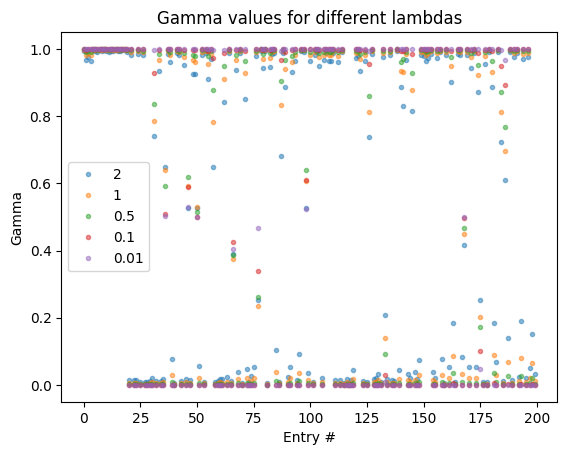

In [10]:
for gamma in mean_gammas:
    plt.plot(range(D), mean_gammas[gamma], '.', label=gamma, alpha=0.5)
plt.legend()
plt.title("Gamma values for different lambdas")
plt.ylabel("Gamma")
plt.xlabel("Entry #")

Text(0.5, 0.98, 'True Beta vs. Estimated Beta')

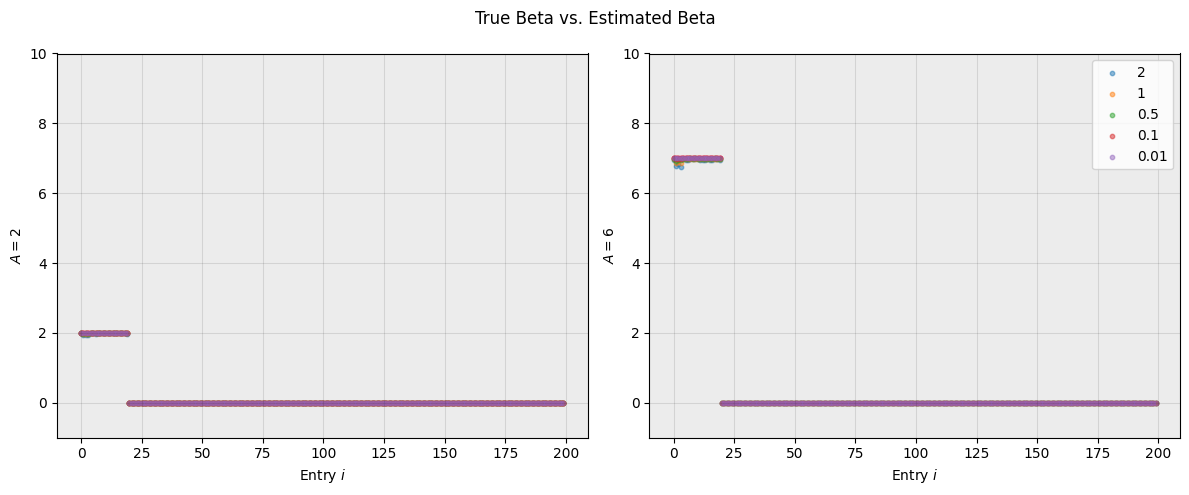

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), layout="tight")
for ax in [ax1, ax2]: 
    ax.set_facecolor("#ECECEC") # set graph background color to grey
    ax.grid(visible=True, color="black", alpha=0.1) # add grid lines

# resetting y-axis range so that the graphs line up
ax2.set_ylim([-1, 10]) 
ax1.set_ylim([-1, 10])

beta_star_7 = np.zeros(D)
beta_star_7[:pstar] = 7
beta_star_2 = np.zeros(D)
beta_star_2[:pstar] = 2

ax1.scatter(range(D), beta_star_2, color='red', s=10) # plot actual betas
ax2.scatter(range(20), beta_star_7[:20], color='red', s=10) 
for lam in lams:
    ax1.scatter(range(D), mean_betas[lam][2], s=10, alpha=0.5, label=lam)
    ax2.scatter(range(D), mean_betas[lam][7], s=10, alpha=0.5, label=lam)

# add labels to graph
ax1.set(ylabel=r'$A=2$', xlabel=r'Entry $i$')
ax2.set(ylabel=r'$A=6$', xlabel=r'Entry $i$')
plt.legend()
fig.suptitle("True Beta vs. Estimated Beta")


In [12]:
mean_gammas[1][0:20]
mean_gammas[1][0:20] * beta_star_7[:20]
print(mean_betas[1][7][:20])
mean_gammas[1][0:20] * beta_star_7[:20]

[6.976336  6.8743954 6.9203196 6.874174  6.985893  6.983477  6.9700646
 6.9876723 6.982787  6.9894905 6.9827013 6.973583  6.9803615 6.9810696
 6.985285  6.982668  6.9740195 6.9903326 6.986971  6.9693217]


Array([6.976336 , 6.8743954, 6.9203196, 6.874174 , 6.985893 , 6.983477 ,
       6.9700646, 6.9876723, 6.982787 , 6.9894905, 6.9827013, 6.973583 ,
       6.9803615, 6.9810696, 6.985285 , 6.982668 , 6.9740195, 6.9903326,
       6.986971 , 6.9693217], dtype=float32)

In [13]:
for lam in lams:
    mean_mses[lam] = dict()
    for A in A_values:
        mean_mses[lam][A] = all_mses[lam][A].mean()
mean_mses[1]

{1: 4.5491756e-06,
 2: 1.8196703e-05,
 3: 4.0942665e-05,
 4: 7.278681e-05,
 5: 0.00011372919,
 6: 0.00016377066,
 7: 0.00022290951,
 8: 0.00029114724,
 9: 0.0003684835,
 10: 0.00045491676}

Text(0.5, 1.0, 'Mean Squared Error for Different Lambda Values')

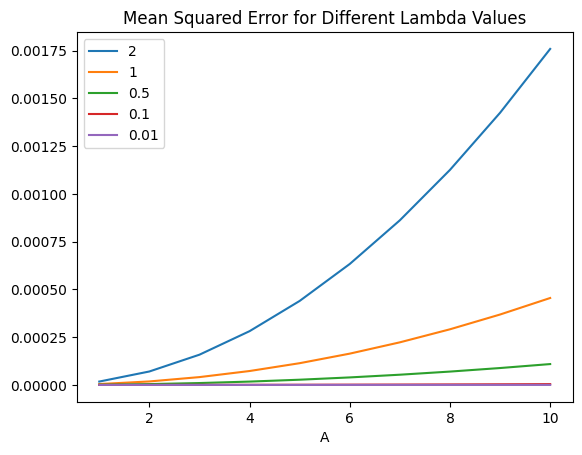

In [14]:

for lam in lams:
    plt.plot(mean_mses[lam].keys(), mean_mses[lam].values(), label=f'{lam}')

ax = plt.gca()
plt.legend()
plt.xlabel("A")
plt.title("Mean Squared Error for Different Lambda Values")

As the value of $\lambda$ decreases, the distribution of $\kappa$ values becomes more concentrated around $0$ and $1$.

(-0.001, 1.001)

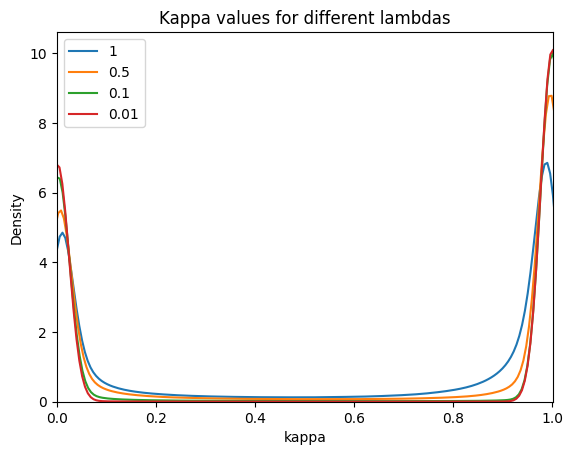

In [17]:
for lam in [1, 0.5, 0.1, 0.01]:
    all_kappas[lam] = np.ndarray.flatten(np.array(all_kappas[lam]))
    sns.kdeplot(all_kappas[lam], label=f'{lam}')
plt.legend()
plt.xlabel("kappa")
plt.title("Kappa values for different lambdas")
plt.xlim(-0.001, 1.001)

(-0.001, 1.001)

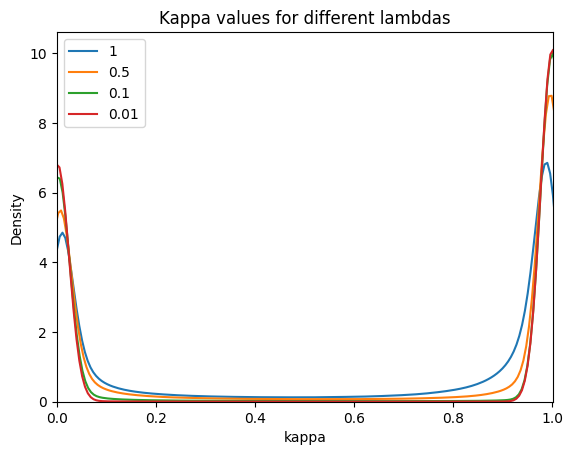

In [18]:
sns.color_palette("hls", 8)
for lam in [1, 0.5, 0.1, 0.01]:
    sns.kdeplot(all_kappas[lam], label=f'{lam}')
plt.legend()
plt.xlabel("kappa")
plt.title("Kappa values for different lambdas")
plt.xlim(-0.001, 1.001)
